In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

from scipy.stats import entropy
import pandas as pd
import numpy as np
import onnxruntime as rt

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# constants and parameters definition

data_path = '../data/300k_dataset.csv'
good_model_path = '../model/good_model.onnx'
biased_model_path = '../model/biased_model.onnx'
image_path = '../images/'
sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw','persoonlijke_eigenschappen_spreektaal']
fairness_threshold = 0.05 

In [3]:
test = sns.color_palette("pastel")
print(test)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393), (1.0, 0.7058823529411765, 0.5098039215686274), (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), (1.0, 0.6235294117647059, 0.6078431372549019), (0.8156862745098039, 0.7333333333333333, 1.0), (0.8705882352941177, 0.7333333333333333, 0.6078431372549019), (0.9803921568627451, 0.6901960784313725, 0.8941176470588236), (0.8117647058823529, 0.8117647058823529, 0.8117647058823529), (1.0, 0.996078431372549, 0.6392156862745098), (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]


In [24]:
# functions definition

def metamorphic_testing(model_path, data_address, sensitive_attributes, fairness_threshold=0.05):
    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
    X = X.astype(np.float32)
    sensitive_data = data[sensitive_attributes]

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    fairness_violations = {}

    for attr in sensitive_attributes:
        print(f"Testing fairness for attribute: {attr}")
        modified_X = X.copy()
        unique_values = sensitive_data[attr].unique()
        if len(unique_values) < 2:
            print(f"Attribute {attr} has less than two unique values, skipping.")
            continue
        new_value = unique_values[1] if sensitive_data[attr].iloc[0] == unique_values[0] else unique_values[0]
        modified_X[attr] = new_value

        preds_original = session.run(None, {input_name: X.values.astype(np.float32)})[0]
        preds_modified = session.run(None, {input_name: modified_X.values.astype(np.float32)})[0]

        if preds_original.ndim > 1:
            preds_original = np.argmax(preds_original, axis=1)
            preds_modified = np.argmax(preds_modified, axis=1)

        change_mask = preds_original != preds_modified
        change_rate = change_mask.mean()

        if change_rate > fairness_threshold:
            fairness_violations[attr] = {
                "change_rate": change_rate,
                "changed_samples": sensitive_data[change_mask],
                "violation": True
            }
            print(f"Fairness violation detected for {attr}: {change_rate:.2%}")
        else:
            fairness_violations[attr] = {
                "change_rate": change_rate,
                "changed_samples": sensitive_data[change_mask],
                "violation": False
            }
            print(f"No significant fairness violation for {attr} (Change rate: {change_rate:.2%}).")

    return fairness_violations

def visualize_fairness_bar(violations, sensitive_attributes):
    for attr, result in violations.items():
        # if result['change_rate'] == 0:
        #     print(f"No changes detected for {attr}, skipping visualization.")
        #     continue

        changed_samples = result['changed_samples']
        attr_values = changed_samples[attr].value_counts()

        plt.figure(figsize=(10, 6))
        # sns.set(style="whitegrid")
        # sns.barplot(x=attr_values.index, y=attr_values.values, color = sns.color_palette("husl", 9)[6])
        # sns.barplot(x=attr_values.index, y=attr_values.values)
        plt.bar(attr_values.index, attr_values.values,color="orange")
        plt.title(f"Prediction Change Distribution for \'{attr}\'", fontsize=14, fontweight='bold')
        plt.xlabel(f"{attr}", fontsize=14, fontweight='bold')
        plt.ylabel("Count of Prediction Changes", fontsize=14,fontweight='bold')
        plt.xticks(rotation=45, fontsize=14)
        plt.yticks(fontsize=14) 
        plt.tight_layout()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(f"{image_path}metatest_{attr}_changes.png")
        plt.show()

def print_res(violations):
    for attr, result in violations.items():
        print(f"--- Results for {attr} ---")
        print(f"Change rate: {result['change_rate']:.2%}")
        print(f"Fairness violation: {result['violation']}")

Testing fairness for attribute: persoon_leeftijd_bij_onderzoek
No significant fairness violation for persoon_leeftijd_bij_onderzoek (Change rate: 0.00%).
Testing fairness for attribute: persoon_geslacht_vrouw
No significant fairness violation for persoon_geslacht_vrouw (Change rate: 0.00%).
Testing fairness for attribute: persoonlijke_eigenschappen_spreektaal
No significant fairness violation for persoonlijke_eigenschappen_spreektaal (Change rate: 0.11%).
--- Results for persoon_leeftijd_bij_onderzoek ---
Change rate: 0.00%
Fairness violation: False
--- Results for persoon_geslacht_vrouw ---
Change rate: 0.00%
Fairness violation: False
--- Results for persoonlijke_eigenschappen_spreektaal ---
Change rate: 0.11%
Fairness violation: False


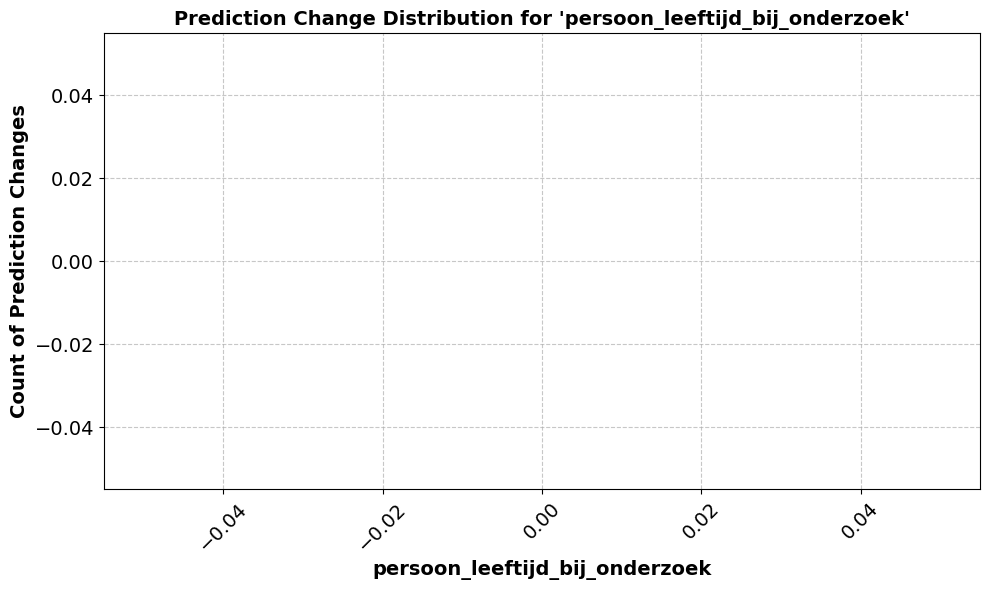

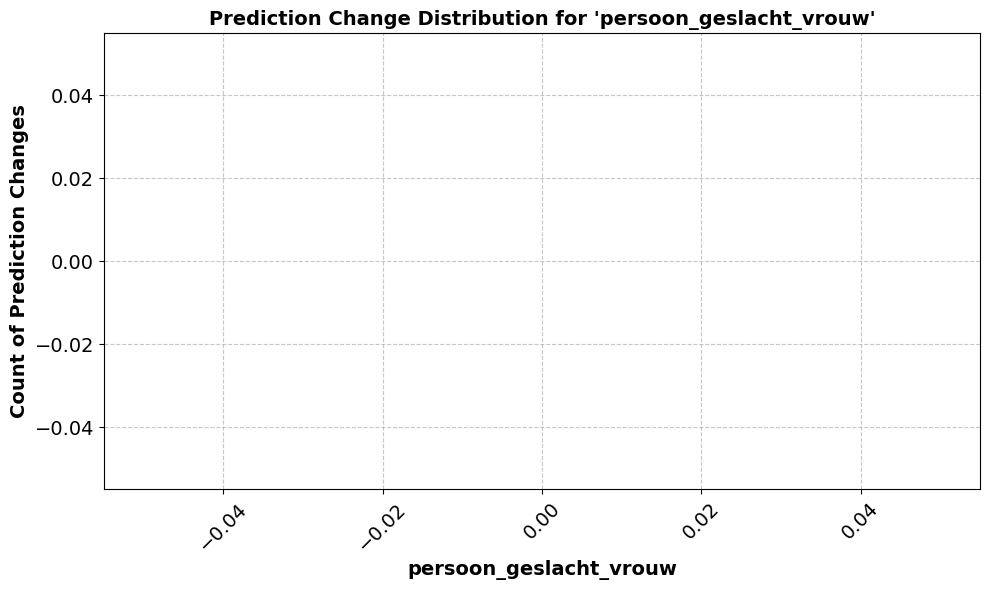

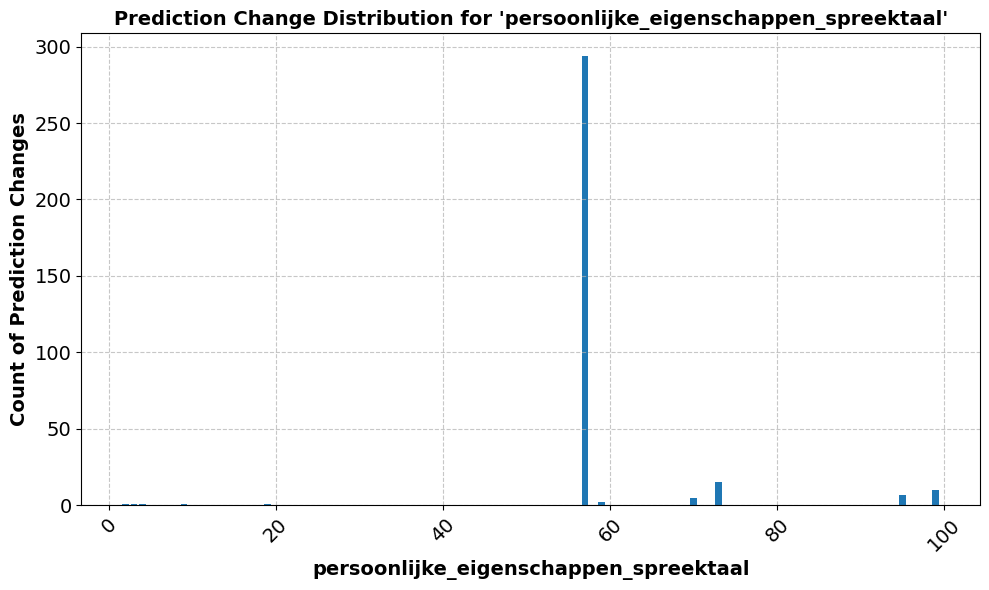

In [19]:
# test and visualize

violations = metamorphic_testing(
    good_model_path,
    data_path,
    sensitive_attributes=sensitive_attributes,
    fairness_threshold=fairness_threshold
)
print_res(violations)
visualize_fairness_bar(violations, sensitive_attributes)

Testing fairness for attribute: persoon_leeftijd_bij_onderzoek
Fairness violation detected for persoon_leeftijd_bij_onderzoek: 7.14%
Testing fairness for attribute: persoon_geslacht_vrouw
Fairness violation detected for persoon_geslacht_vrouw: 8.16%
Testing fairness for attribute: persoonlijke_eigenschappen_spreektaal
Fairness violation detected for persoonlijke_eigenschappen_spreektaal: 11.76%
--- Results for persoon_leeftijd_bij_onderzoek ---
Change rate: 7.14%
Fairness violation: True
--- Results for persoon_geslacht_vrouw ---
Change rate: 8.16%
Fairness violation: True
--- Results for persoonlijke_eigenschappen_spreektaal ---
Change rate: 11.76%
Fairness violation: True


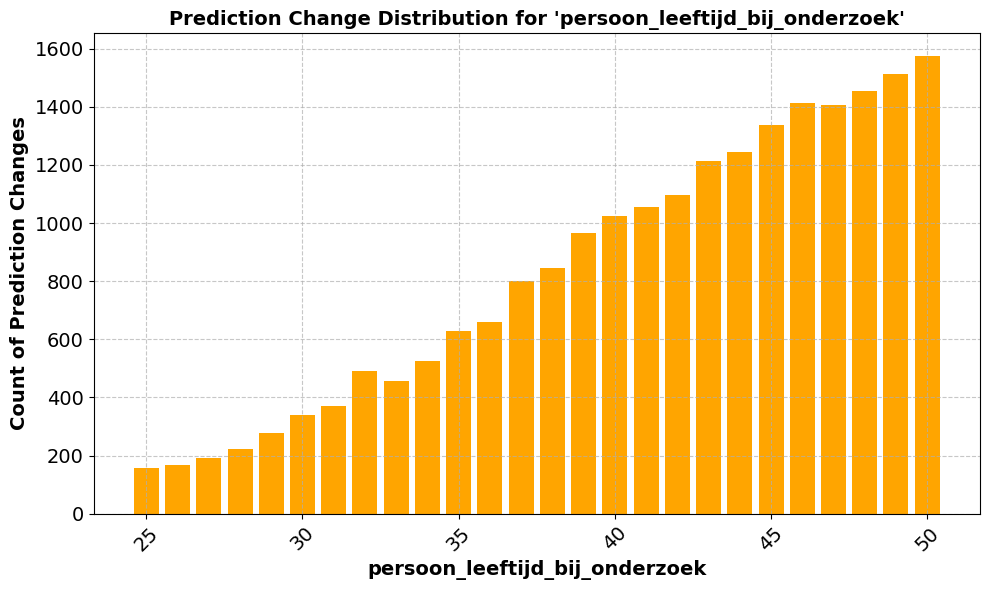

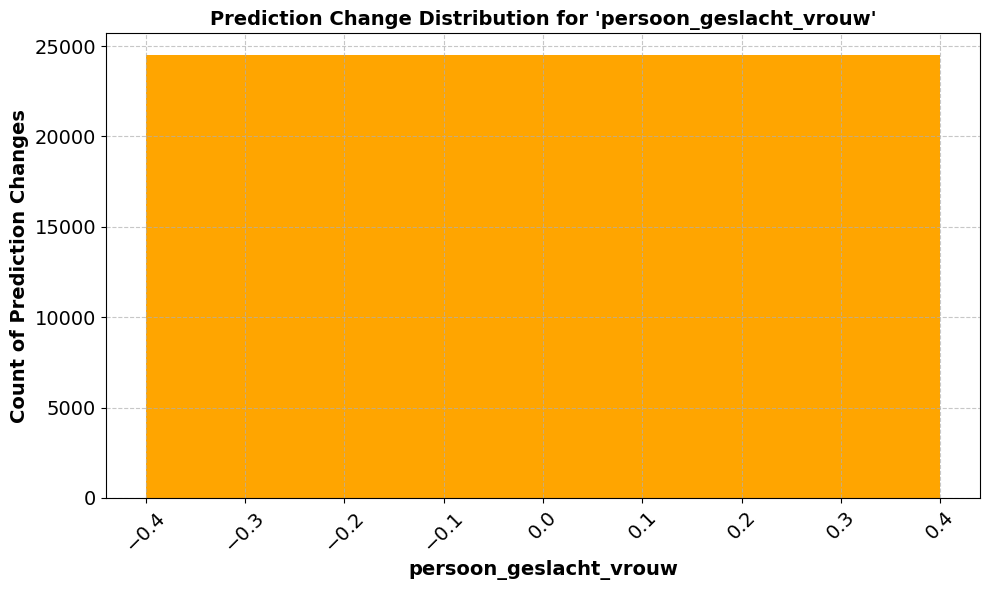

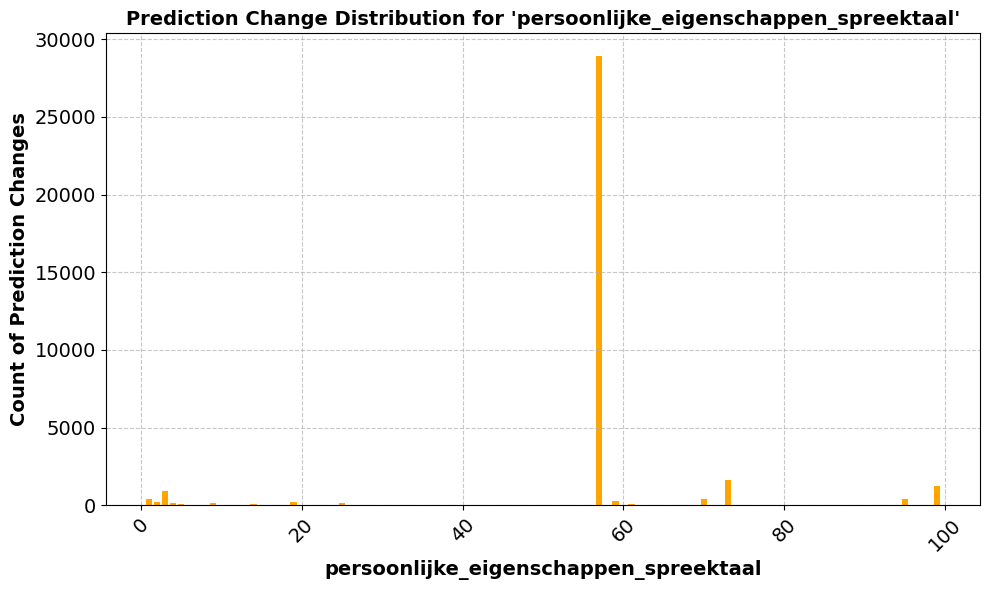

In [25]:
# test and visualize

violations = metamorphic_testing(
    biased_model_path,
    data_path,
    sensitive_attributes=sensitive_attributes,
    fairness_threshold=fairness_threshold
)
print_res(violations)
visualize_fairness_bar(violations, sensitive_attributes)

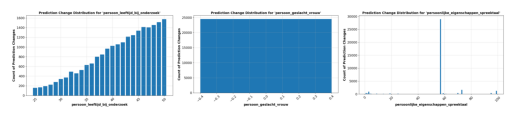

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

image1 = Image.open('../images/metatest_1.png')
image2 = Image.open('../images/metatest_2.png')
image3 = Image.open('../images/metatest_3.png')
image4 = Image.open('../images/metatest_4.png')
image5 = Image.open('../images/metatest_5.png')
image6 = Image.open('../images/metatest_6.png')

combined_width = image4.size[0] + image5.size[0] + image6.size[0]
combined_image = Image.new('RGB', (combined_width, image1.size[1]))
combined_image.paste(image4, (0, 0))
combined_image.paste(image5, (image4.size[0], 0))
combined_image.paste(image6, (image4.size[0] + image5.size[0], 0))

plt.imshow(combined_image)
plt.axis('off')
combined_image.save('../images/metatest_biased_model.jpg', format='JPEG')